[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qiuyi-Hong/SHEMS/blob/main/analysisSHEMS_v3.ipynb)

In [1]:
# # Install necessary packages: 
# !pip install pyomo pandas openpyxl matplotlib jupyter

# # Install cbc solver: 
# !sudo apt-get install  coinor-cbc coinor-libcbc-dev 

# # Download necessary files:
# import urllib.request, sys

# urls = [
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.py',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.dat',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/Simulation%20Results/simulation_results_concatenated.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/agile-half-hour-actual-rates-25-01-2023_26-01-2024.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/simulation_results_completed.csv',
#     ]
# file_names = [url.split('/')[-1] for url in urls]

# for i in range(len(urls)):
#     urllib.request.urlretrieve(urls[i], file_names[i])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
%matplotlib inline
import pyomo.environ as pyo
from SHEMS_v3 import model 

In [3]:
data = pd.read_csv("simulation_results_completed.csv")
data.head()

,Date,Dry-bulb temperature (°C),Total system energy (kBtu/h),System natural gas (kBtu/h),System electricity (kBtu/h),Total lights energy (kBtu/h),Lights electricity (kBtu/h),Total equip energy (kBtu/h),Equip electricity (kBtu/h),Total CE ex equip (kgCO2/h),...,Electricity (mu),Gas (mu),Renewables (mu),Total nat. gas (kBtu/h),Total electricity (kBtu/h),Total grid displaced elec. PV (kBtu/h),Total energy (kBtu/h),Transformer Losses (kBtu/h),Agile Import price (p/kWh),Agile Export price (p/kWh)
0,2023-01-01 00:00:00,5.5,7.460,7.325,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.325,3.048,0.0,10.372,0.0,4.41,2.77
1,2023-01-01 00:30:00,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0,13.91,6.86
2,2023-01-01 01:00:00,5.5,7.468,7.333,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.333,3.048,0.0,10.380,0.0,15.44,7.52
3,2023-01-01 01:30:00,5.5,7.467,7.331,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.331,3.048,0.0,10.379,0.0,1.10,1.34
4,2023-01-01 02:00:00,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0,6.70,3.76


In [4]:
data.set_index('Date', inplace=True)
# Slice the DataFrame from a start date to the end
start_date = '2023-01-25 00:00:00'
data = data.loc[start_date:]
data.reset_index(inplace=True)

# Convert the format of the start date for the figure file name
modified_start_date = start_date.replace(':', '_').replace(' ', '_')

In [5]:
# Solar PV generation
eta = 0.157
S = 20
solar_radiation = data["Direct radiation (W/m²)"]/1000
outdoor_temp = data["Dry-bulb temperature (°C)"]

pv = eta * S * solar_radiation *(1 - 0.005 * (outdoor_temp - 25))

In [6]:
# COP calculation
a = - 0.087
b = 6.8 
COP = a * (outdoor_temp + 30 - outdoor_temp) + b 

In [7]:
T = 48
delta_t = 0.5
demand_ele = data["Total electricity (kBtu/h)"] * 0.29307107
# demand_heat = data["Total nat. gas (kBtu/h)"] * 0.29307107

# Electricity price
ele_import_price = data["Agile Import price (p/kWh)"]
ele_export_price = data["Agile Export price (p/kWh)"]

In [8]:
# Accurate T_inlet calculation
T_TES_init = 55 
Q_TES_init = 12
V_TES = 0.3

T_inlet = T_TES_init - (Q_TES_init * 3.6e6)/(V_TES * 1000 * 4186)
T_inlet

20.599617773530817

# SHEMS

In [9]:
shems = model.create_instance("SHEMS_v3.dat", namespace="base")

In [10]:
for t in range(1,T+1):
    shems.d_ele._data[t].value = demand_ele[t-1]
    # shems.d_heat._data[t].value = demand_heat[t-1]
    shems.p_pv._data[t].value = pv[t-1]
    shems.pi_import._data[t].value = ele_import_price[t-1]
    shems.pi_export._data[t].value = ele_export_price[t-1]
    shems.T_out._data[t].value = outdoor_temp[t-1]
    shems.COP._data[t].value = COP[t-1]
    shems.T_TES_init.value = T_TES_init
    shems.Q_TES_init.value = Q_TES_init
    shems.V_TES.value = V_TES
    shems.T_inlet.value = T_inlet

In [11]:
from sys import platform

if platform == "linux":
    # linux
    solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
elif platform == "darwin":
    # maxOS
    # solver = pyo.SolverFactory('cplex', executable = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex')
    # solver = pyo.SolverFactory('scip', solver_io='nl')
    solver = pyo.SolverFactory('cbc')

solver.solve(shems)

{'Problem': [{'Name': 'unknown', 'Lower bound': 975.82718375, 'Upper bound': 975.82718375, 'Number of objectives': 1, 'Number of constraints': 286, 'Number of variables': 332, 'Number of binary variables': 96, 'Number of integer variables': 96, 'Number of nonzeros': 96, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.39, 'Wallclock time': 0.43, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 14, 'Number of created subproblems': 14}, 'Black box': {'Number of iterations': 1454}}, 'Error rc': 0, 'Time': 0.4555079936981201}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
obj_value = pyo.value(shems.obj)
print("Objective function value:", obj_value)

Objective function value: 975.8271813857999


## Visualisation

In [13]:
# Values of decision variables
values = pd.DataFrame(data={'T_TES': [shems.T_TES._data[t].value for t in range(1,T+1)],
                            'q_HP': [shems.q_HP._data[t].value for t in range(1,T+1)],                           
                            'p_HP': [shems.p_HP._data[t].value for t in range(1,T+1)],
                            'q_SH': [shems.q_SH._data[t].value for t in range(1,T+1)],
                            'q_DHW': [shems.q_DHW._data[t].value for t in range(1,T+1)],
                            'T_in': [shems.T_in._data[t].value for t in range(1,T+1)],
                            'epsilon_SH': [shems.epsilon_SH._data[t].value for t in range(1,T+1)],
                            'epsilon_TES': [shems.epsilon_TES._data[t].value for t in range(1,T+1)],
                            'Q_TES': [shems.Q_TES._data[t].value for t in range(1,T+1)],
                            'q_TES_d': [shems.q_TES_d._data[t].value for t in range(1,T+1)],
                            'p_import': [shems.p_import._data[t].value for t in range(1,T+1)],
                            'p_export': [shems.p_export._data[t].value for t in range(1,T+1)],
                            'd_heat': [shems.d_heat._data[t].value for t in range(1,T+1)]})
                      

In [14]:
values.head()

,T_TES,q_HP,p_HP,q_SH,q_DHW,T_in,epsilon_SH,epsilon_TES,Q_TES,q_TES_d,p_import,p_export,d_heat
0,53.592661,0.000000,0.000000,0.0,0.000000,19.887688,0.246203,0.981853,11.509073,0.0,0.893281,0.0,0.0
1,52.224543,0.000000,0.000000,0.0,0.000000,19.776189,0.244419,0.954491,11.031828,0.0,0.893281,0.0,0.0
2,50.894551,0.000000,0.000000,0.0,0.000000,19.665499,0.242648,0.927891,10.567882,0.0,0.893281,0.0,0.0
3,50.000000,0.285902,0.068234,0.0,0.285902,19.555611,0.240890,0.910000,10.255833,0.0,0.927398,0.0,0.0
4,50.000000,0.910000,0.217184,0.0,0.910000,19.446518,0.239144,0.910000,10.255833,0.0,1.001872,0.0,0.0


In [15]:
T_TES = [shems.T_TES._data[t].value for t in range(1,T+1)]
q_HP = [shems.q_HP._data[t].value for t in range(1,T+1)]
p_HP = [shems.p_HP._data[t].value for t in range(1,T+1)]
q_SH = [shems.q_SH._data[t].value for t in range(1,T+1)]
q_DHW = [shems.q_DHW._data[t].value for t in range(1,T+1)]
T_in = [shems.T_in._data[t].value for t in range(1,T+1)]
epsilon_SH = [shems.epsilon_SH._data[t].value for t in range(1,T+1)]
epsilon_TES = [shems.epsilon_TES._data[t].value for t in range(1,T+1)]
Q_TES = [shems.Q_TES._data[t].value for t in range(1,T+1)]
q_TES_d = [shems.q_TES_d._data[t].value for t in range(1,T+1)]
p_import = [shems.p_import._data[t].value for t in range(1,T+1)]
p_export = [shems.p_export._data[t].value for t in range(1,T+1)]

d_ele = [shems.d_ele._data[t].value for t in range(1,T+1)]
d_heat = [shems.d_heat._data[t].value for t in range(1,T+1)]
p_pv = [shems.p_pv._data[t].value for t in range(1,T+1)]

### Electricity Profile

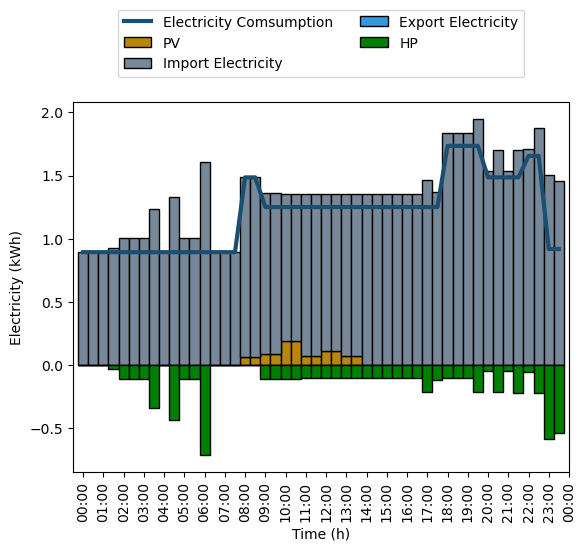

In [16]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_ele), label="Electricity Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(p_pv)*delta_t, width=bar_width, label="PV", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(p_import), bottom=np.array(p_pv)*delta_t, width=bar_width, label="Import Electricity", color="#778899", edgecolor="black")

ax1.bar(time_range, np.negative(p_export), width=bar_width, label="Export Electricity", color="#3498DB", edgecolor="black")

ax1.bar(time_range, np.negative(p_HP)*delta_t, bottom=np.negative(p_export), width=bar_width, label="HP", color="#008000", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity (kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"shems_electricity_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Heat Consumption

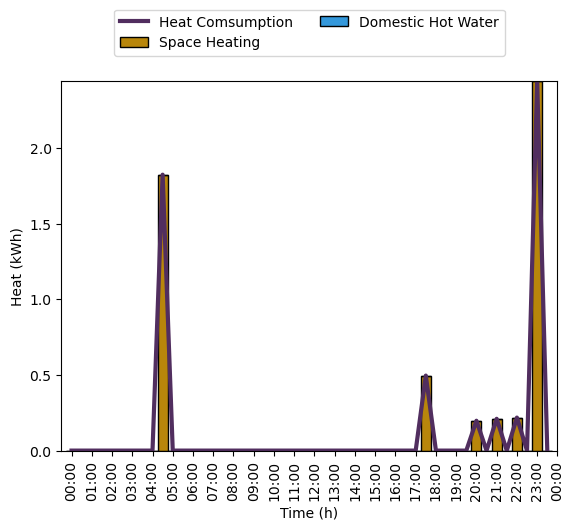

In [17]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#512E5F", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_SH)*delta_t, width=bar_width, label="Space Heating", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(q_TES_d)*delta_t, bottom= np.array(q_SH)*delta_t, width=bar_width, label="Domestic Hot Water", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"shems_heat_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### HP Operation

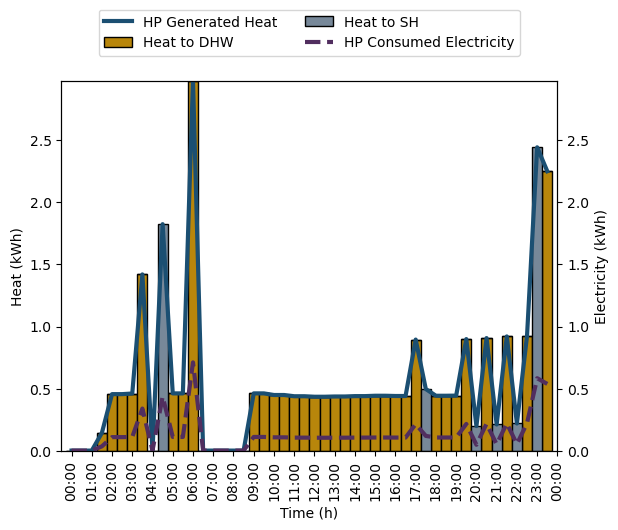

In [18]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(q_HP)*delta_t, label="HP Generated Heat", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

# ax1.plot(time_range, np.array(p_HP)*delta_t, label="HP Consumed Electricity", color="#512E5F", linestyle=lineStyle[2], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="Heat to DHW", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(q_SH)*delta_t, bottom=np.array(q_DHW)*delta_t, width=bar_width, label="Heat to SH", color="#778899", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Set the range of the y-axis for ax1
ax1.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(p_HP)*delta_t, label="HP Consumed Electricity", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Electricity (kWh)")

# Set the range of the y-axis for ax2
ax2.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.savefig(f"shems_HP_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### TES Operation

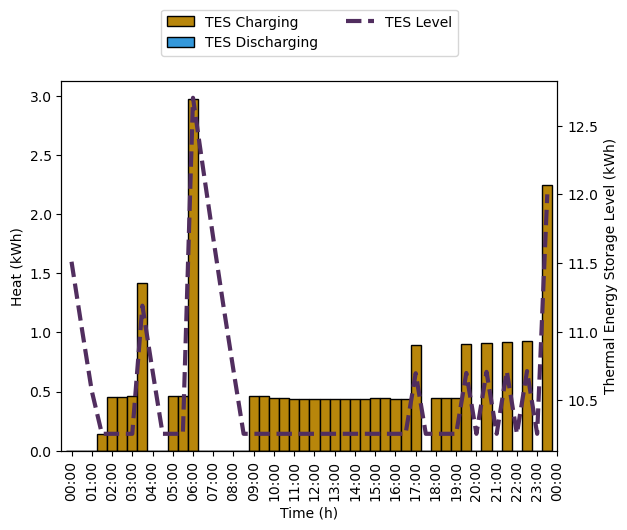

In [19]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

# ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="TES Charging", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.negative(q_TES_d)*delta_t, width=bar_width, label="TES Discharging", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(Q_TES), label="TES Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Thermal Energy Storage Level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"shems_TES_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Temperature Comfort Control

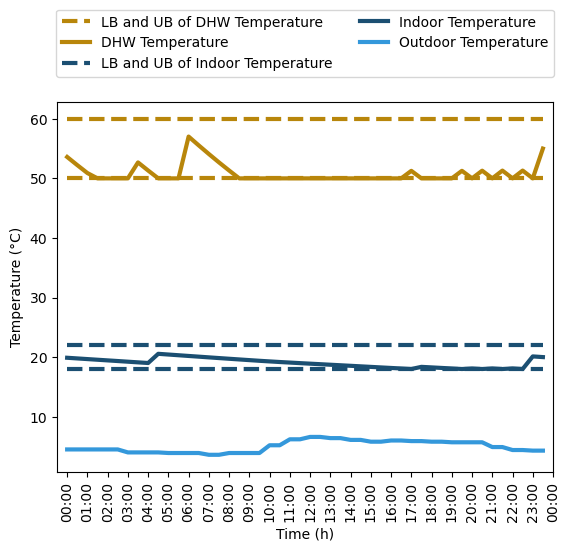

In [20]:
T_TES_LB = shems.T_TES_LB.value
T_TES_UB = shems.T_TES_UB.value

T_in_LB = shems.T_in_LB.value
T_in_UB = shems.T_in_UB.value

T_out = [shems.T_out._data[t].value for t in range(1,T+1)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array([T_TES_UB]*T), label="LB and UB of DHW Temperature", color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_TES), label="DHW Temperature", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_TES_LB]*T), color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array([T_in_UB]*T), label="LB and UB of Indoor Temperature", color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_in), label="Indoor Temperature", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_in_LB]*T), color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_out), label="Outdoor Temperature", color="#3498DB", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Temperature (°C)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"shems_temperature_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Import & Export Electricity Prices

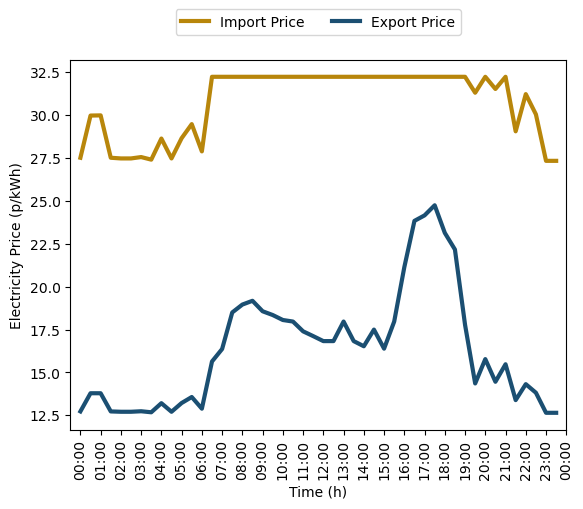

In [21]:
pi_import = [shems.pi_import._data[t].value for t in range(1,T+1)]
pi_export = [shems.pi_export._data[t].value for t in range(1,T+1)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(pi_import), label="Import Price", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array(pi_export), label="Export Price", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity Price (p/kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"electricity_prices_v3_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()